## Flow Matching for Trajectories
* Adapted from https://github.com/dome272/Flow-Matching/blob/main/flow-matching.ipynb


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from torch import nn
import torch
import os
import statistics as stat
import time
import datetime

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA version: {torch.version.cuda}")
torch.cuda.set_device('cuda:0')

## Frame and Trajectory generation
* A potential issue with trajectory generation is the incredible length needed to go from one end of the area to the other. Since the next point is in no way optimized to reaching a destination, the trajectories are quite non-smooth and do not "utilize" their length in a beneficial manner.
* That being said, this might not matter if the model is sufficiently able.
* A discussion about wether or not the trajectories should be anchored to some valid start/goal locations, and then be free to move is in order.

In [ ]:
# Frame dimensions
x_min, x_max = -100, 100
y_min, y_max = -100, 100

# Define pillar dimensions
pillar_width = 0.6 * (x_max - x_min)
pillar_height = 0.25 * (y_max - y_min)

# Calculate pillar bounds
pillar_x_min = x_min
pillar_x_max = x_min + int(pillar_width)
pillar_y_min = y_min + (y_max - y_min) // 2 - int(pillar_height / 2)
pillar_y_max = pillar_y_min + int(pillar_height)

pillar = (pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max)

def is_inside_pillar(x, y, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
    return (pillar_x_min <= x < pillar_x_max) and (pillar_y_min <= y < pillar_y_max)

def is_oob(x, y, x_min, x_max, y_min, y_max):
    return (x < x_min or x > x_max) or (y < y_min or y > y_max)

def generate_trajectories(num_trajectories, num_steps, x_min, x_max, y_min, y_max):
    trajectories = []

    while len(trajectories) < num_trajectories:
        while True:
            # Start position
            x_start = np.random.uniform(x_min, x_max)
            y_start = np.random.uniform(y_min, y_max)
            if not is_inside_pillar(x_start, y_start, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
                break  # Valid start point found

        trajectory = [(x_start, y_start)]

        for _ in range(num_steps - 1):
            while True:
                # New position steps
                x_new = trajectory[-1][0] + np.random.normal(0, 1) * 10 # Multiply to increase step length
                y_new = trajectory[-1][1] + np.random.normal(0, 1) * 10

                # Check if the new point is within bounds and outside the pillar
                if not is_oob(x_new, y_new, x_min, x_max, y_min, y_max) and not is_inside_pillar(x_new, y_new, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
                    trajectory.append((x_new, y_new))
                    break  # Valid point found, exit loop
        
        trajectories.append(trajectory)

    return np.array(trajectories)

In [ ]:
# Parameters
num_trajectories = 10
num_steps = 300

# Generate valid trajectories
valid_trajectories = generate_trajectories(num_trajectories, num_steps, x_min, x_max, y_min, y_max)

def show_trajectories(valid_trajectories):
    plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max]) # Frame

    plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5) # "Pillar"

    # Plot valid trajectories
    for count, trajectory in enumerate(valid_trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}")

    plt.title("Valid Trajectories with 'Blocked Area'")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

## Show Trajectories

In [ ]:
show_trajectories(valid_trajectories)

## Model Architecture

In [ ]:

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(max_positions) / (half_dim - 1)
        frequencies = torch.arange(half_dim, device=t.device).float().mul(-emb_scale).exp()
        emb = t[..., None] * frequencies
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)

        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x) # Projects the 2D data to a larger number (512)
        t = self.gen_t_embedding(t) # Includes timestep t with cosine/sine embeddings
        t = self.t_projection(t) # Linear layer on top of previous steps^^
        x_extended = x.unsqueeze(2).expand(-1, -1, t.size(2), -1)
        x = x_extended + t  # Timestep embedding to the input.
        x = self.blocks(x) # Linear layers and ReLu activations
        x = self.out_projection(x)
        return x

In [ ]:
model = MLP(layers=5, channels=512).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
model_path = "mlp_model.pt"

## Load pretrained model

In [ ]:
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.eval()

## Training

In [ ]:
import tqdm
data = torch.tensor(valid_trajectories, dtype=torch.float32, device=device)
print(f"Device: {data.get_device()}")
num_steps = data.shape[1]
num_trajectories = data.shape[0] 
training_steps = 1000000 #1000000 = ca. 7 timer, 100000 = ca. 42 minutter, 10000 ca. 4 min
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    batch_indices = torch.randint(data.size(0), (batch_size,), device=device)
    x1 = data[batch_indices]
    x0 = torch.randn_like(x1)
    target = x1 - x0 # The target the NN should try to predict. See eq. (10) in Multisample FM paper
    target = target.unsqueeze(2).expand(-1, num_steps, -1, -1)
    t = torch.rand(x1.size(0), device=device)
    t = t[:, None, None] 
    t = t.expand(t.size(0), num_steps, 2)
    xt = (1 - t) * x0 + t * x1
    pred = model(xt, t)
    loss = ((target - pred) ** 2).mean() # L2 loss, see eq. (7) in Multisample FM paper
    loss.backward()
    optim.step()
    optim.zero_grad()   
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

# torch.save(model.state_dict(), model_path)

## Losses
* Plotting
* Saving

Closing file


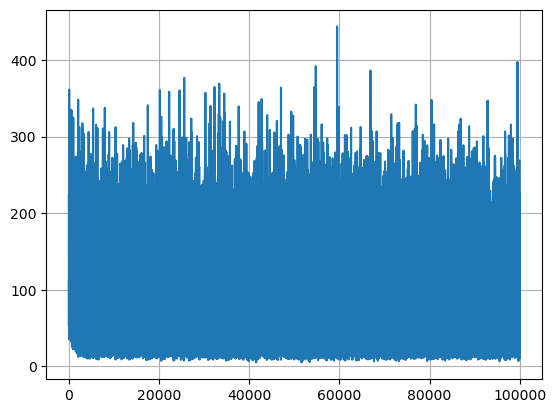

In [11]:
# torch.save(model.state_dict(), model_path)
plt.plot(losses)
plt.grid()
final_loss = losses[-1]
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

loss_file = "Loss_data.csv"
access_mode = "w+" # Both reading and writing, most importantly creates a file if one does not already exist

try:
    ts = time.time()
    sttime = datetime.datetime.fromtimestamp(ts).strftime('%d %m %Y %H:%M:%S')
    file = open(loss_file, access_mode)
    file.write(f"Final loss value: {final_loss}\n")
    file.write(f"Average loss value: {avg_loss}\n")
    file.write(f"Median loss value: {med_loss}\n")
except IOError as e:
    print(f"An error occured: {e}")
finally:
    print(f"Closing file")
    file.close()

In [12]:
print(f"Last loss value: {losses[-1]}")
print(f"Average loss value: {sum(losses)/len(losses)}")
print(f"Median loss value: {stat.median(losses)}")

Last loss value: 120.857421875
Average loss value: 87.21956447425366
Median loss value: 79.85343170166016


## Interpolation

In [13]:
# Directly from MPOT code repo:
# https://github.com/anindex/mpot/blob/main/mpot/utils/trajectory.py#L4


def interpolate_trajectory(trajs: torch.Tensor, num_interpolation: int = 3) -> torch.Tensor:
    # Interpolates a trajectory linearly between waypoints
    dim = trajs.shape[-1]
    if num_interpolation > 0:
        assert trajs.ndim > 1
        traj_dim = trajs.shape
        alpha = torch.linspace(0, 1, num_interpolation + 2).type_as(trajs)[1:num_interpolation + 1]
        alpha = alpha.view((1,) * len(traj_dim[:-1]) + (-1, 1))
        interpolated_trajs = trajs[..., 0:traj_dim[-2] - 1, None, :] * alpha + \
                             trajs[..., 1:traj_dim[-2], None, :] * (1 - alpha)
        interpolated_trajs = interpolated_trajs.view(traj_dim[:-2] + (-1, dim))
    else:
        interpolated_trajs = trajs
    return interpolated_trajs

## ODE Solver

In [14]:
from torchdiffeq import odeint
class ODEFunc(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        t_tensor = torch.full_like(x[:, :, :1], t)
        pred = self.model(x, t_tensor)[:, :, 0, :]
        return pred

## Sampling
* Problem with sampling as of 29.01 is that there is noe apparent connection between the points generated, causing eventual trajectories to "clog" the entire image instead of actually following the distribution given by the points.
* In other words, the way trajectories are generated do not take into account (it seems at least) the distribution, instead only connecting points that are next to each other in the list, instead of next to each other in the actual space of the image. 

Plotting Progress:   0%|          | 0/10 [00:00<?, ?it/s]

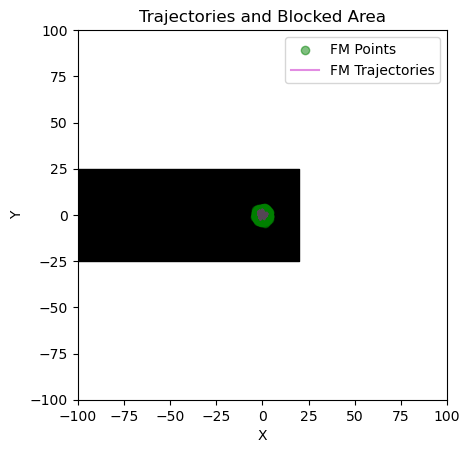

Plotting Progress:  10%|█         | 1/10 [00:00<00:03,  2.43it/s]

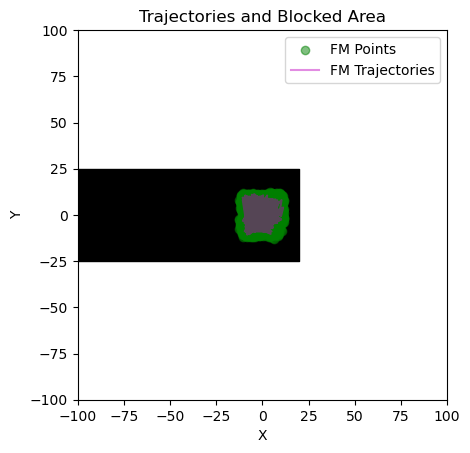

Plotting Progress:  20%|██        | 2/10 [00:00<00:03,  2.39it/s]

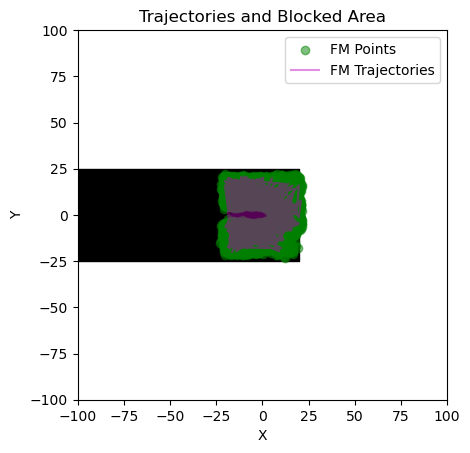

Plotting Progress:  30%|███       | 3/10 [00:01<00:02,  2.41it/s]

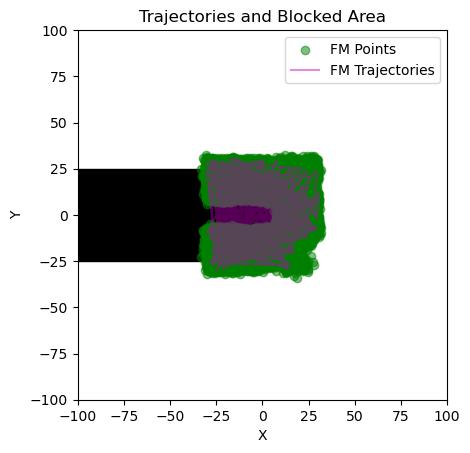

Plotting Progress:  40%|████      | 4/10 [00:01<00:02,  2.31it/s]

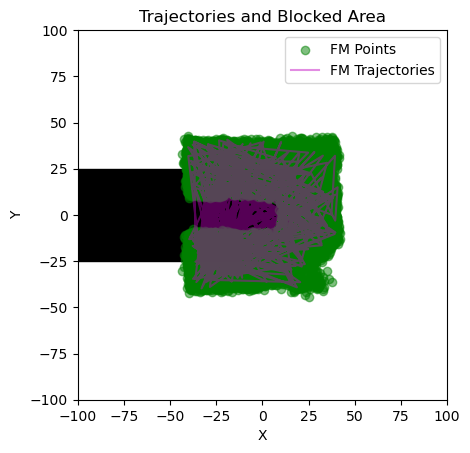

Plotting Progress:  50%|█████     | 5/10 [00:02<00:02,  2.33it/s]

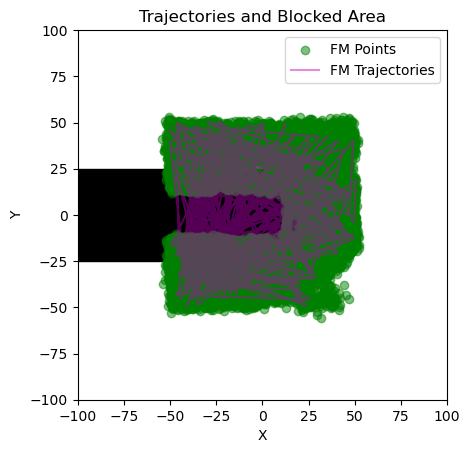

Plotting Progress:  60%|██████    | 6/10 [00:02<00:01,  2.33it/s]

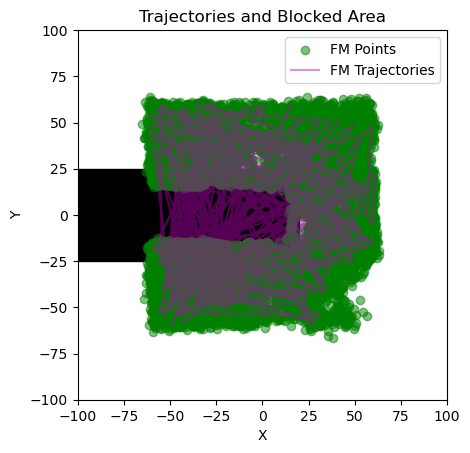

Plotting Progress:  70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

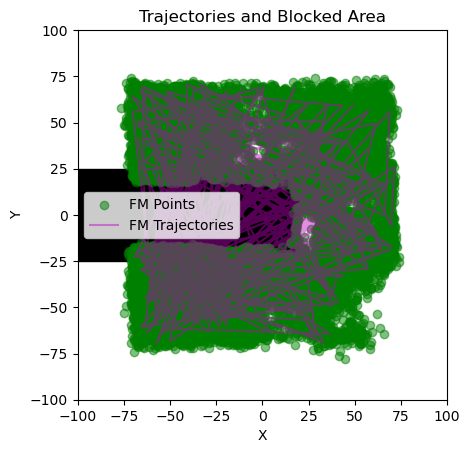

Plotting Progress:  80%|████████  | 8/10 [00:03<00:01,  1.81it/s]

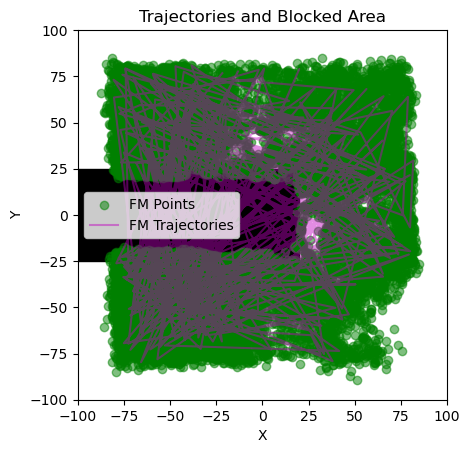

Plotting Progress:  90%|█████████ | 9/10 [00:04<00:00,  1.57it/s]

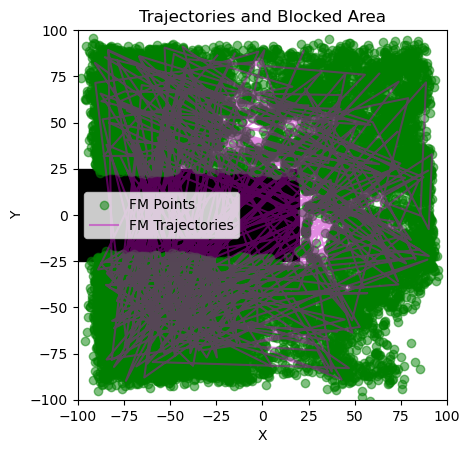

Plotting Progress: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

Done sampling


In [22]:
from tqdm import tqdm

batch_size = 64
torch.manual_seed(42)
model.eval().requires_grad_(False)

xt = torch.randn(batch_size, num_steps, 2, device=device)
steps = 10000
plot_every = 1000
t_eval = torch.linspace(0, 1, steps, device=device)

ode_func = ODEFunc(model)
xt = odeint(ode_func, xt, t_eval, method='rk4')

results_dir = os.path.join(os.getcwd(), "Progression/")
os.makedirs(results_dir, exist_ok=True)

for i in tqdm(range(0, steps, plot_every), desc="Plotting Progress"):
    xt_i = xt[i]
    plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])
    plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='black')
    plt.scatter(xt_i[:, :, 0].detach().cpu().numpy(), xt_i[:, :, 1].detach().cpu().numpy(), color='green', alpha=0.5, label="FM Points")
    
    for traj in xt_i.detach().cpu().numpy():
        plt.plot(traj[:, 0], traj[:, 1], color='m', alpha=0.45, label="FM Trajectories")
        break

    plt.title("Trajectories and Blocked Area")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.savefig(os.path.join(results_dir, f"FM_Progression{i}.png"))
    plt.show()
    plt.close()

model.train().requires_grad_(True)
print("Done sampling")


In [ ]:
# batch_size = 64
# torch.manual_seed(42)
# model.eval().requires_grad_(False)

# xt = torch.randn(batch_size, num_steps, 2, device=device)
# steps = 10000
# plot_every = 1000
# t_eval = torch.linspace(0, 1, steps, device=device)

# ode_func = ODEFunc(model)
# xt = odeint(ode_func, xt, t_eval, method='rk4')

# for i in range(0, steps, plot_every):
#     xt_i = xt[i]
#     plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])
#     plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='black')
#     plt.scatter(xt_i[:, :, 0].detach().cpu().numpy(), xt_i[:, :, 1].detach().cpu().numpy(), color='green', alpha=0.5, label="FM Points")
    
#     for traj in xt_i.detach().cpu().numpy():
#         plt.plot(traj[:, 0], traj[:, 1], color='m', alpha=0.45, label="FM Trajectories")
#         break

#     plt.title("Trajectories and Blocked Area")
#     plt.xlabel("X")
#     plt.ylabel("Y")
#     plt.legend()
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)

#     results_dir = os.path.join(os.getcwd(), "Progression/")
#     os.makedirs(results_dir, exist_ok=True)
#     plt.savefig(os.path.join(results_dir, f"FM_Progression{i}.png"))
#     plt.show()
#     plt.close()

# model.train().requires_grad_(True)
# print("Done sampling")


In [16]:
# Original Euler version


# batch_size = 64
# torch.manual_seed(42)
# model.eval().requires_grad_(False)
# xt = torch.randn(batch_size, num_steps, 2, device=device) # Generates a point/trajectory for sampling defined by each step in trajectory (num_steps)
# # xt = torch.randn(batch_size, num_trajectories, 2, device=device) # Generates a point/trajectory that equals the amount of trajectories (more appropriate then num_steps)
# steps = 1000 # Add more steps?
# plot_every = 100
# for i, t in enumerate(torch.linspace(0, 1, steps, device=device), start=1):
#     # Euler integration that probably needs to be replaced with an ODE solver
#     # ---------------------------------------------------------------------
#     t = t.view(1, 1, 1).expand(xt.size(0), xt.size(1), xt.size(2))
#     pred = model(xt, t)
#     pred = pred[:, :, 0, :]
#     xt = xt + (1/steps) * pred
#     # ---------------------------------------------------------------------

#     # Plotting
#     if i % plot_every == 0:
#         plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])
#         plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='black')
        
#         # Valid trajectories (dataset)

#         # for count, trajectory in enumerate(valid_trajectories):
#         #     trajectory = np.array(trajectory)
#         #     plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}", alpha=0.5)

#         plt.scatter( # Points
#             xt[:, :, 0].detach().cpu().numpy(), # detach from computation tracked by PyTorch autograd
#             xt[:, :, 1].detach().cpu().numpy(), # Move from GPU memory to CPU memory so that it can be converted into NumPy array
#             color='green', alpha=0.5, label="FM Points"
#             )
#         for traj in xt.detach().cpu().numpy(): # Trajectories
#             plt.plot(traj[:, 0], traj[:, 1], color='m', alpha=0.45, label="FM Trajectories")
#             break
        
#         # int_trajs = interpolate_trajectory(traj, num_interpolation=3) # Usikker på hvilken tensor denne funksjonen egentlig skal ta inn
#         # plt.plot(int_trajs[:, 0].detach().cpu().numpy(), int_trajs[:, 1].detach().cpu().numpy(), color='orange', label="Interpolated trajectories")

#         plt.title("Trajectories and Blocked Area")
#         plt.xlabel("X")
#         plt.ylabel("Y")
#         plt.legend()
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)

#         # Save the plots
#         script_dir = os.getcwd()
#         results_dir = os.path.join(script_dir, "Progression/")
#         fig_name = f"FM_Progression{i}.png"
#         os.makedirs(results_dir, exist_ok=True)
#         plt.savefig(os.path.join(results_dir, fig_name))
#         plt.show()
#         plt.close()

# model.train().requires_grad_(True) 
# print("Done sampling")